# Multiprocessing in Python: Dynamic Programming Application
### by [Jason DeBacker](http://jasondebacker.com), December 2017
This Jupyter Notebook solves the optimal investment problem of the firm using VFI -- with a speed boost by using the `multiprocessing` package to paralleize the solution algorithm.


## 1. Overview of the Theory
The firm's optimization problem can be written as:

$$ V(z,k) = max_{k'} \pi(z,k) - p^{k}(k'-(1-\delta)k) - c(k',k) + \beta V(z',k') $$

We going to assume that $z$ is deterministic and stationary.  Thus we'll set $z=1$ for all time and drop it from our vector of state variables.  In addition, assume that the price of new capital is equal to one; $p^{k}=1$.  Rewriting the problem we have:

$$ V(k) = max_{k'} \pi(k) - (k'-(1-\delta)k) - c(k',k) + \beta V(k') \ \ (1) $$ 

We need to solve for $V(k)$ and the policy function, $k'=h(k)$.  To do this, we are going to use the recursive nature of the problem.  In particular, we are going to use a fixed point algorithm and the fact that the value funciton, $V(\cdot)$ appears on both sides of the equation above.

In particular, we are going to look for the fixed point for the mapping $T(V(k))$ defined as 

$$ T(V(k)) = max_{k'} \pi(k) - (k'-(1-\delta)k) - c(k',k) + \beta V(k') $$

Here, $V(k)$ represents a proposed solution to the Equation (1) above.  If $T(V(k))=V(k)$ then $V(k)$ *is* the solution to (1).  Value function iteration uses this mapping to find the solution.  Under certain assumptions, it is shown that such a solution exists, is unique, and can be found by iterating on any initial proposed value function.  See Stokey, Lucas, and Prescott (1989, pp. 49-55) for details on the necessary conditions for the existence and uniqueness of a solution.  Suffice it to say, those conditions are met in the problem as parameterized below.

The approach we'll take, then, is to guess an initial value function, $V_{0}(k)$ and then iterate on this guess with the operators $T(v(k))$ so that we have:

$$ V_{i+1}(k) = max_{k'} \pi(k) - (k'-(1-\delta)k) - c(k',k) + \beta V_{i}(k') $$

Where $i$ denotes the iteration.  These iterations will continue until $V_{i+1}(k)=V_{i}(k)$, i.e., when we've found the fixed point.  This fixed point will be the solution to our problem, $V(k)=V_{i}(k)$.  With this found, we can then find the policy function, $h(k)$ that corresponds to this value function.

## 2. Setting things up.

In [4]:
# Import packages
import numpy as np
import matplotlib.pyplot as plt
import time

# to print plots inline
%matplotlib inline

### 2.1 Parameterization
To solve a numerical problem, we need to set values to the parameters.  We also need to specify the adjustment cost function.  Adjustment costs will be assumed to be quadratic:

$$ c(k',k) = \frac{\psi}{2}\left(\frac{k'-(1-\delta)k}{k}\right)^{2}k $$

Operating profits are given by $zk^{\alpha_{k}}$

Or, noting that $z=1$ in the deterministic model we're studying here:

$$ \pi(k)=k^{\alpha_{k}} $$

We then choose the following parameterization:

| Paramter | Description   | Value|
|------|------||------|
    | $\alpha_{k}$ | Capital's share of output | 0.6 |
   | $\delta$ | Depreciation rate | 0.154 |
   | $\psi$ | Coefficient on quadratic adjustment costs | 1.080 |
   | $r$   | Interest rate | 0.040 |
   | $z$   | Productivity | 1.000 |



In [117]:
# specify parameters
alpha_k = 0.6
delta = 0.154
psi = 1.08
r= 0.04
z = 1

To determine the discount rate of the firm, we have:



In [116]:
betafirm = (1 / (1 + r))

### 2.2 Discretizing the state space for capital

In [133]:
dens = 12
# put in bounds here for the capital stock space
kbar = 24
lb_k = 0.001
ub_k = kbar
krat = np.log(lb_k / ub_k)
numb = np.ceil(krat / np.log(1 - delta))
K = np.zeros(int(numb * dens))
# we'll create in a way where we pin down the upper bound - since
# the distance will be small near the lower bound, we'll miss that by little
for j in range(int(numb * dens)):
    K[j] = ub_k * (1 - delta) ** (j / dens)
kgrid = K[::-1]
sizek = kgrid.shape[0]

### 2.3 Grid of per period flows

In order to evaluate our value functions, we will need to know the per period flows to the firm.  These are given by operating profits, $\pi(k)$, less investment expenses plus adjustment costs, $I + c(k',k)$.

As noted above, operating profits (with $z=1$) are given by:

$$
\pi(k) =k^{\alpha_{k}}
$$
Per period flows are then:

$$ e(k,k') = \pi(k) - (k'-(1-\delta)k) - \frac{\psi}{2}\left(\frac{k'-(1-\delta)k}{k}\right)^{2}k $$

In [134]:
# operating profits, op
op = ((1 - alpha_l) * ((alpha_l / w) ** (alpha_l / (1 - alpha_l))) *
      ((kgrid ** alpha_k) ** (1 / (1 - alpha_l))))

# firm cash flow, e
e = np.zeros((sizek, sizek))
for i in range(sizek):
    for j in range(sizek):
            e[i, j] = (op[i] - kgrid[j] + ((1 - delta) * kgrid[i]) -
                       ((psi / 2) * ((kgrid[j] - ((1 - delta) * kgrid[i])) ** 2)
                        / kgrid[i]))

## 3. Value Function Iteration

We've now determined all the fundamental objects we need to do value function iteration over a discete grid.  There are a few more objects we need to create that determine when convergence has been reached and to ensure that our `while` loops end.  We'll also want to intialize arrays that will be populated in our VFI.  

Note that any initial guess at the value function $V_{0}$ will work.  But closer guesses will mean less iterations until convergence.  Here, we just guess a vector of zeros.  We know it's not the solution, but it gives us a starting point.

In [135]:
VFtol = 1e-6
VFmaxiter = 3000
VFdist = 7.0
V = np.zeros(sizek)  # initial guess at value function
Vmat = np.zeros((sizek, sizek))  # initialize Vmat matrix
Vstore = np.zeros((sizek, VFmaxiter))  # initialize Vstore array
VFiter = 1

### 3.1 Useful VFI functions

To interpolate the value function at each iteration of the  VFI solution method, it'll be helpful to define a few functions that we can call during the solution method.  Let's define functions for operating profits, adjustment costs, and firm cash flows.

In [136]:
def op_profits(k, params):
    """
    Operating profits function
    """
    alpha_k = params
    op = k ** alpha_k
    
    return op

            
def adj_cost(k, kprime, params):
    """
    Adjustment cost function
    """
    psi, delta = params
    cost = (psi / 2) * ((kprime - (1 - delta) * k) ** 2) / k
    
    return cost


def cash_flow(k, kprime, params):
    """
    Cash flow function
    """
    alpha_k, psi, delta = params
    op_params = (alpha_k)
    cost_params = (psi, delta)
    e = op_profits(k, op_params) - kprime + (1 - delta) * k - adj_cost(k, kprime, cost_params)
    
    return e

Next, we'll define a function for the Bellman operator itself: $V_{i+1} = T(V_{i})$.  We are using a funciton for this now since we are doing more than just applyin the $max$ operator at each step, we are now interpolating the value function and choosing the optimal $k'$ using the interpolation of $V(k')$.  

In [137]:
# write Bellman operator function to help with VFI
from scipy.optimize import fminbound

def bellman_operator(V, kgrid, params):
    """
    The approximate Bellman operator, which computes and returns the
    updated value function TV on the grid points.  An array to store
    the new set of values TV is optionally supplied (to avoid having to
    allocate new arrays at each iteration).  If supplied, any existing data in 
    Tw will be overwritten.
    """
    betafirm, alpha_k, psi, delta = params
    e_params = (alpha_k, psi, delta)
    
    # Apply linear interpolation to V
    V_func = lambda x: np.interp(x, kgrid, V)

    # Initialize array for operator and policy function
    TV = np.empty_like(V)
    optK = np.empty_like(TV)

    # == set TV[i] = max_k' { e(k,k') + beta V(k')} == #
    for i, k in enumerate(kgrid):
        def objective(kprime):
            return - cash_flow(k, kprime, e_params) - betafirm * V_func(kprime)
        kprime_star = fminbound(objective, 1e-10, kgrid[-1])
        optK[i] = kprime_star
        TV[i] = - objective(kprime_star)

    return TV, optK

## 3.2 Solving the firm's problem with VFI
Finally, we'll write our VFI "while" loop.  This loop will call the Bellman operator at each iteration until convergence.

In [138]:
# Reset distance, etc
VFdist = 7.0
V = np.zeros(sizek)  # initial guess at value function
Vmat = np.zeros((sizek, sizek))  # initialize Vmat matrix
Vstore = np.zeros((sizek, VFmaxiter))  # initialize Vstore array
VFiter = 1

# Now solve VFI using bellman operator function (and thus interpolation)
V_params = (betafirm, alpha_k, psi, delta)
start_time = time.time()
while VFdist > VFtol and VFiter < VFmaxiter:
    Vstore[:, VFiter] = V
    TV, optK_serial = bellman_operator(V, kgrid, V_params)
    VFdist = (np.absolute(V - TV)).max()  # check distance between value
    # function for this iteration and value function from past iteration
    V = TV
    VFiter += 1

VFI_time = time.time() - start_time
if VFiter < VFmaxiter:
    print('Value function converged after this many iterations:', VFiter)
else:
    print('Value function did not converge')
print('VFI took ', VFI_time, ' seconds to solve')


VF_serial = V  # solution to the functional equation

Value function converged after this many iterations: 373
VFI took  190.29308104515076  seconds to solve


## 4.  Using parallelization to speed up the solution

Now let's consider using parallelization to speed up the solution.  To do this, let's rewrite the Bellman operator function to take advantage of Python's multiprocessing library:

In [139]:
import multiprocessing
    
# Apply linear interpolation to V
V_func = lambda x: np.interp(x, kgrid, V)
    
# Define objective function
def objective(kprime, k, e_params, betafirm):
        return - cash_flow(k, kprime, e_params) - betafirm * V_func(kprime)

# == set TV = max_k' { e(k,k') + beta V(k')} == #
def TV_func(k, e_params, betafirm):
    kprime_star = fminbound(objective, 1e-10, kgrid[-1], args=(k, e_params, betafirm))
    optK_val = kprime_star
    TV_val = - objective(kprime_star, k, e_params, betafirm)
    return TV_val, optK_val

def bellman_operator_mp(V, kgrid, params):
    """
    The approximate Bellman operator, which computes and returns the
    updated value function TV on the grid points.  An array to store
    the new set of values TV is optionally supplied (to avoid having to
    allocate new arrays at each iteration).  If supplied, any existing data in 
    Tw will be overwritten.
    """
    betafirm, alpha_k, psi, delta = params
    e_params = (alpha_k, psi, delta)
    
    # Initialize array for operator and policy function
    TV = np.empty_like(V)
    optK = np.empty_like(TV)
    
    results = {}
    pool = multiprocessing.Pool()
    for i, k in enumerate(kgrid):
        results[i] = pool.apply_async(TV_func, args=(k, e_params, betafirm))
    pool.close()
    pool.join()
    for i, result in results.items():
        TV[i], optK[i] = result.get()
 
    return TV, optK

Now we'll paste our VFI loop code below, but call the new Bellman operator function that uses multiprocessing.

In [130]:
# Reset distance, etc
VFdist = 7.0
VFmaxiter = 1000
V = np.zeros(sizek)  # initial guess at value function
Vmat = np.zeros((sizek, sizek))  # initialize Vmat matrix
Vstore = np.zeros((sizek, VFmaxiter))  # initialize Vstore array
VFiter = 1

# Now solve VFI using bellman operator function (and thus interpolation)
V_params = (betafirm, alpha_k, psi, delta)
start_time = time.time()
while VFdist > VFtol and VFiter < VFmaxiter:
    Vstore[:, VFiter] = V
    TV, optK_parallel = bellman_operator_mp(V, kgrid, V_params)
    VFdist = (np.absolute(V - TV)).max()  # check distance between value
    # function for this iteration and value function from past iteration
    V = TV
    VFiter += 1

VFI_time = time.time() - start_time
if VFiter < VFmaxiter:
    print('Value function converged after this many iterations:', VFiter)
else:
    print('Value function did not converge')
print('VFI took ', VFI_time, ' seconds to solve')


VF_parallel = V  # solution to the functional equation

Value function converged after this many iterations: 373
VFI took  151.5178279876709  seconds to solve


## 5. Compare output!


## 5.1 Plotting the value functions.

Text(0.5,1,'Value Function - deterministic firm w/ adjustment costs')

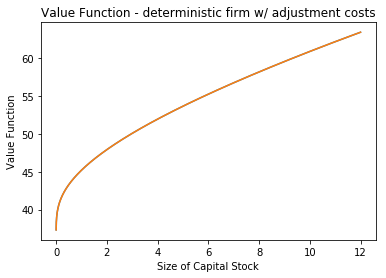

In [131]:
plt.plot(kgrid, VF_serial)
plt.plot(kgrid, VF_parallel)
plt.xlabel('Size of Capital Stock')
plt.ylabel('Value Function')
plt.title('Value Function - deterministic firm w/ adjustment costs')

## 5.2 Plot the policy functions

Here we'll plot investment policy function as a rate, $\frac{I}{k}$.

Text(0.5,1,'Policy Function, Next Period Capoital - deterministic firm w/ adjustment costs')

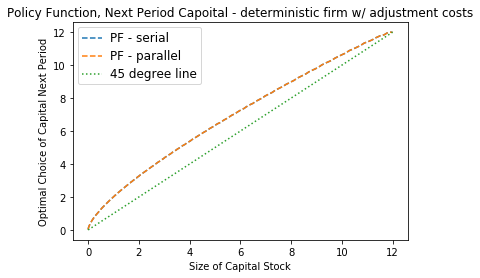

In [132]:
# Plot optimal capital stock rule as a function of firm size
fig, ax = plt.subplots()
ax.plot(kgrid, optK_serial, '--', label='PF - serial')
ax.plot(kgrid, optK_serial, '--', label='PF - parallel')
ax.plot(kgrid, kgrid, ':', label='45 degree line')
# Now add the legend with some customizations.
legend = ax.legend(loc='upper left', shadow=False)
# Set the fontsize
for label in legend.get_texts():
    label.set_fontsize('large')
for label in legend.get_lines():
    label.set_linewidth(1.5)  # the legend line width
plt.xlabel('Size of Capital Stock')
plt.ylabel('Optimal Choice of Capital Next Period')
plt.title('Policy Function, Next Period Capoital - deterministic firm w/ ' +
          'adjustment costs')

## 7. References
* Stokey, Nancy L. and Robert E. Lucas and Edward C. Prescott, *Recursive Methods in Economic Dynamics*, Harvard University Press (1989).